In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Anomaly detection
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose

# NLP
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:

data = pd.read_csv('MASTER_MSFT_FINAL.csv',index_col=[0])
stock_data = pd.read_csv('MSFT_STOCK.csv',index_col=[0])

In [3]:
# Calculate daily returns
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Calculate rolling statistics
window_size = 250  # You can adjust this window size
stock_data['Rolling_Mean'] = stock_data['Close'].rolling(window=window_size).mean()
stock_data['Rolling_Std'] = stock_data['Close'].rolling(window=window_size).std()

# Calculate Bollinger Bands
stock_data['Bollinger_High'] = stock_data['Rolling_Mean'] + (stock_data['Rolling_Std'] * 2)
stock_data['Bollinger_Low'] = stock_data['Rolling_Mean'] - (stock_data['Rolling_Std'] * 2)

# Drop NaN values resulting from rolling calculations
stock_data.dropna(inplace=True)

In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume,Daily_Return,Rolling_Mean,Rolling_Std,Bollinger_High,Bollinger_Low
Date,,,,,,,,,,,
2000-12-27,23.062500,23.406250,22.500000,23.218750,14.316539,69003800,-0.009333,38.239250,8.548510,55.336271,21.142229
2000-12-28,22.562500,23.125000,21.937500,22.281250,13.738487,77619200,-0.040377,38.095250,8.512682,55.120614,21.069886
2000-12-29,21.968750,22.906250,21.500000,21.687500,13.372382,99977600,-0.026648,37.956750,8.496756,54.950263,20.963237
2001-01-02,22.062500,22.500000,21.437500,21.687500,13.372382,82413200,0.000000,37.815875,8.473243,54.762361,20.869389
2001-01-03,21.593750,24.437500,21.562500,23.968750,14.778984,135962200,0.105187,37.691750,8.447752,54.587254,20.796246
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,416.369995,417.279999,411.339996,413.489990,413.489990,13152800,-0.007918,393.792360,39.235564,472.263488,315.321233
2024-08-27,412.859985,414.359985,410.250000,413.839996,413.839996,13492900,0.000846,394.134080,39.035346,472.204772,316.063388
2024-08-28,414.880005,415.000000,407.309998,410.600006,410.600006,14882700,-0.007829,394.461320,38.827717,472.116754,316.805887


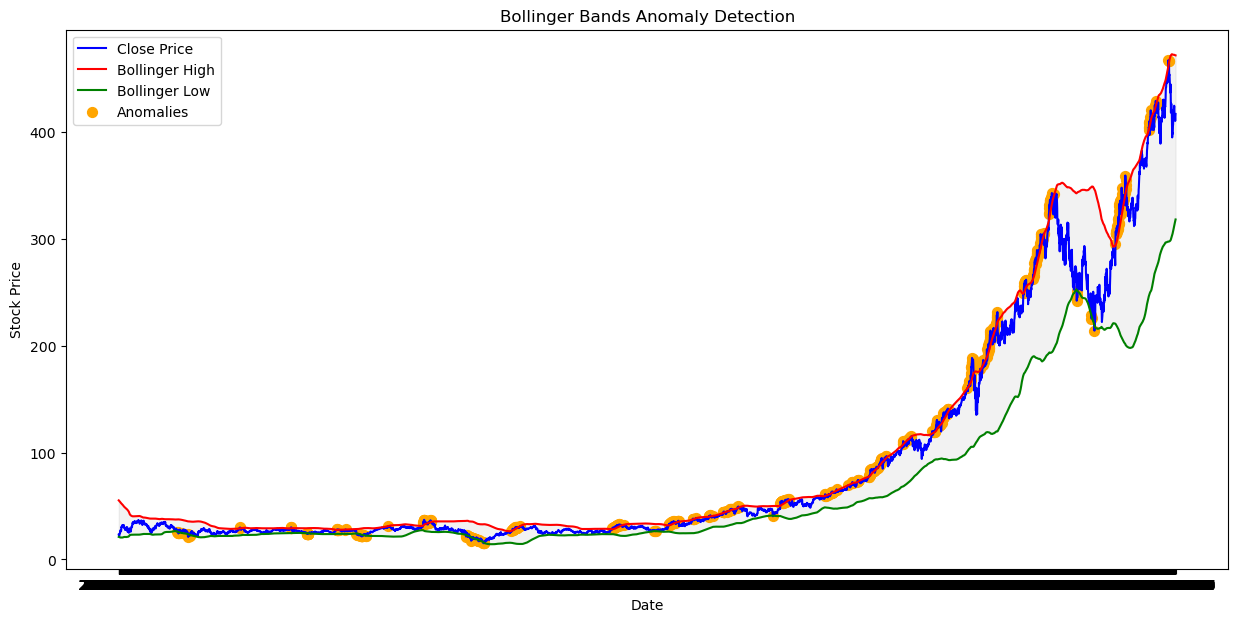

In [5]:
# Identify anomalies where price is outside Bollinger Bands
stock_data['Anomaly_Bollinger'] = np.where(
    (stock_data['Close'] > stock_data['Bollinger_High']) | (stock_data['Close'] < stock_data['Bollinger_Low']),
    1,
    0
)

# Plotting
plt.figure(figsize=(15,7))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue')
plt.plot(stock_data.index, stock_data['Bollinger_High'], label='Bollinger High', color='red')
plt.plot(stock_data.index, stock_data['Bollinger_Low'], label='Bollinger Low', color='green')
plt.fill_between(stock_data.index, stock_data['Bollinger_High'], stock_data['Bollinger_Low'], color='grey', alpha=0.1)
plt.scatter(stock_data[stock_data['Anomaly_Bollinger'] == 1].index, 
            stock_data[stock_data['Anomaly_Bollinger'] == 1]['Close'], 
            label='Anomalies', color='orange', marker='o', s=50)
plt.title('Bollinger Bands Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


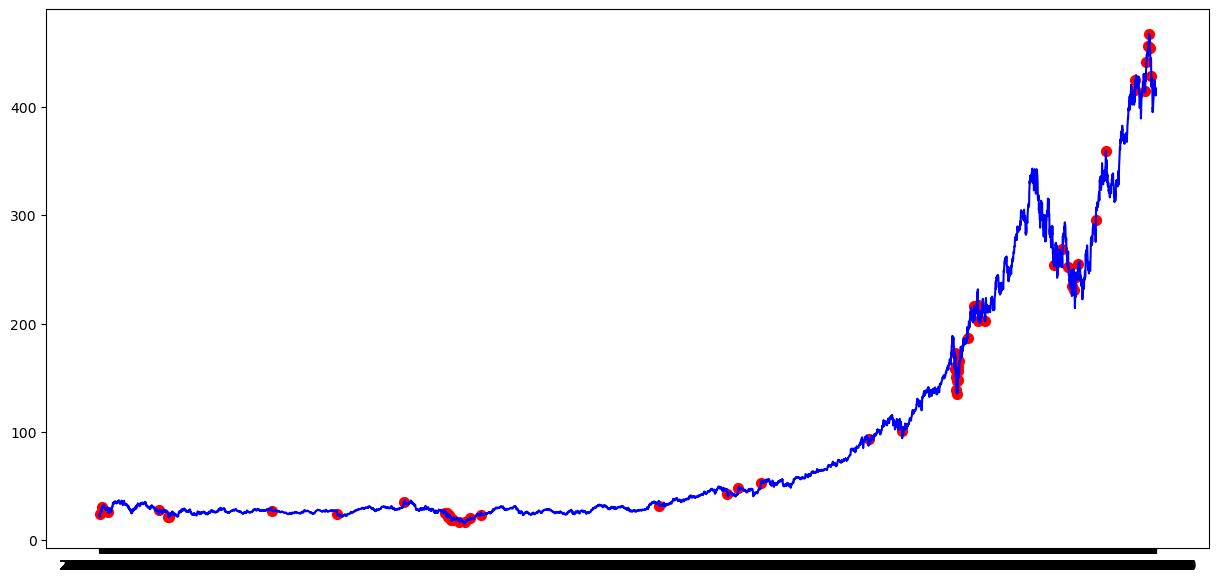

In [11]:
# ISOLATION FOREST
from sklearn.preprocessing import StandardScaler

# Prepare data for modeling
features = stock_data[['Close', 'Daily_Return']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Isolation Forest model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
stock_data['Anomaly_IsoForest'] = iso_forest.fit_predict(scaled_features)

# Mark anomalies
stock_data['Anomaly_IsoForest'] = stock_data['Anomaly_IsoForest'].apply(lambda x: 1 if x == -1 else 0)

# # Plotting
plt.figure(figsize=(15,7))
plt.plot(stock_data.index, stock_data['Close'], label='Close Price', color='blue')
plt.scatter(stock_data[stock_data['Anomaly_IsoForest'] == 1].index, 
            stock_data[stock_data['Anomaly_IsoForest'] == 1]['Close'], 
            label='Anomalies', color='red', marker='o', s=50)
# plt.title('Isolation Forest Anomaly Detection')
# plt.xlabel('Date')
# plt.ylabel('Stock Price')
# plt.legend()
plt.show()


In [15]:
# Reset index to merge on date
stock_anomalies = stock_data.reset_index()[['Date', 'Anomaly_Bollinger', 'Anomaly_IsoForest', 'Anomaly_Residual']]

# Merge with news data
merged_data = pd.merge(data, stock_anomalies, on='Date', how='inner')

# Filter for days with anomalies
anomaly_days = merged_data[
    (merged_data['Anomaly_Bollinger'] == 1) | 
    (merged_data['Anomaly_IsoForest'] == 1) | 
    (merged_data['Anomaly_Residual'] == 1)
]


In [40]:
# Display anomalies with headlines
news_ano = anomaly_days[(anomaly_days['Anomaly_IsoForest'] == 1)][['combined_news','Date']]

In [49]:
news_ano['Date'] = pd.to_datetime(news_ano['Date'])

In [52]:
news_ano['Year'] = news_ano['Date'].dt.year

In [94]:
news_ano.groupby('Year').agg({'combined_news':list}).reset_index()

,Year,combined_news
0,2001,"[Nasdaq soars record 14% - Jan. 3, 2001 - CNN ..."
1,2002,[Nicholsons in Sliema reopens - Times of Malta...
2,2004,[Steve Jobs Vs Bill Gates: How The IPod Create...
3,2006,"[Microsoft misses on earnings, sales in third ..."
4,2007,"[Ten Years, 10 Disruptors - Forbes IFA Hotels ..."
5,2008,[David de Weese of Paul Capital Partners on th...
6,2009,[Worst Stocks Bear Market for 200 Years! - The...
7,2013,[Boxford chef sells special salsa at Middleton...
8,2015,[Blood for sale: India's illegal 'red market' ...
9,2018,[Apple may be working on an Equivalent to Micr...


In [91]:
def analize(x):
    print(x.Date)
    print(x.combined_news)
    print("*********************************************************************")
news_ano.apply(analize,axis=1)

2001-01-03 00:00:00
Nasdaq soars record 14% - Jan. 3, 2001 - CNN Microsoft faces $5bn discrimination claim - The Guardian Currencies: Dollar Continues to Slip as Economy Slows - TheStreet BUSINESS | eToys pulls out of Europe - CBBC Newsround Office Depot to close 70 stores - Jan. 3, 2001 - CNN Big Three post big sales drop - Jan. 3, 2001 - CNN BBC News | SCOTLAND | Scotland in Wal-Mart first - CBBC Newsround
*********************************************************************
2001-01-19 00:00:00
Alcoa Gave O'Neill $59 Million in Pay And Stock Options - The Washington Post Home Depot hits Dow - Jan. 19, 2001 - CNN Snatch movie review & film summary (2001) - Roger Ebert Lock, Stock And Two Smoking Barrels (1997) Movie Review from Eye for Film - Eye For Film Izuel talks stocks: PMCS, COVD, LU - Jan. 19, 2001 - CNN Snatch - Movie Review - Austin Chronicle
*********************************************************************
2001-03-12 00:00:00
Who Blew the Dot-Com Bubble? - The Washington

4       None
15      None
49      None
337     None
389     None
391     None
969     None
1333    None
1710    None
1942    None
1952    None
1959    None
1963    None
1979    None
1981    None
1986    None
2021    None
2053    None
2085    None
2148    None
3151    None
3534    None
3595    None
3722    None
4330    None
4520    None
4814    None
4816    None
4821    None
4822    None
4824    None
4825    None
4826    None
4827    None
4832    None
4834    None
4836    None
4841    None
4887    None
4923    None
4946    None
4948    None
4984    None
5375    None
5422    None
5455    None
5473    None
5486    None
5497    None
5510    None
5610    None
5666    None
5830    None
5832    None
5885    None
5894    None
5906    None
5909    None
5913    None
5922    None
dtype: object